In [4]:
from msdm.algorithms.entregpolicyiteration import entropy_regularized_policy_iteration
from msdm.domains import GridWorld
from msdm.algorithms import ValueIteration
from msdm.core.problemclasses.mdp import TabularPolicy
import numpy as np
import torch
from frozendict import frozendict


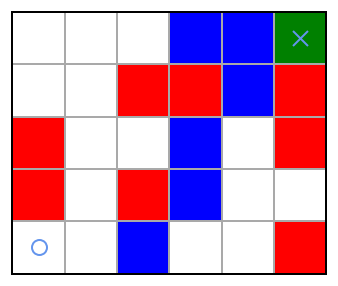

In [5]:
# Create a gridworld
mdp_params = dict(
    tile_array=[
        "...bbg",
        "..xxbx",
        "x..b.x",
        "x.xb..",
        "s.b..x",
    ],
    feature_rewards={
        "x": -100,
        "b": 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=1-1e-5,
    step_cost=-1
)
mdp = GridWorld(**mdp_params)

# mdp = GridWorld(
#     tile_array=[
#         "......c....c.bbg",
#         ".axx....xx.x.bbc",
#         "c.xxx.xxxxbac.xx",
#         "x.xx..xx........",
#         "s.xxaa....c.....",
#         "..xx..xaaa..cxxx",
#         ".xsbbax..s.xxxxx",
#     ],
#     feature_rewards={
#         'g': 10,
#         'x': -500,
#         'c': -5,
#         '.': 0,
#         'a': 0,
#         'b': 0,
#     },
#     absorbing_features=('g'),
#     initial_features=('s'),
#     discount_rate=0.99,
#     step_cost=-1
# )

featurecolors = {
    'g': 'green',
    'x': 'red',
    '.': 'white',
    'b': 'blue'
}
mdp.plot(featurecolors=featurecolors)


In [35]:
# {frozendict({'dx': 1, 'dy': 0}): 0, frozendict({'dx': -1, 'dy': 0}): 1, frozendict({'dx': 0, 'dy': 0}): 2, frozendict({'dy': 1, 'dx': 0}): 3, frozendict({'dy': -1, 'dx': 0}): 4}

def buildFeatures(mdp, features):
  # each state is a one-hot vector of its color
  state_feature_matrix = torch.zeros(len(mdp.state_list), len(features))
  states = mdp.state_index
  
  for state, state_index in states.items():
    f = mdp.location_features.get(state, '.')
    if f in features:
      feature_index = features.index(f)
    else:
      continue
    state_feature_matrix[state_index, feature_index] = 1

  # shape is 1 (state) x 1 (action) x num_states x num_features bc the features only depend on the next_state so for any state and any action, if it ends in next_state i, it should have the features corresponding to next_state i
  state_action_nextstate_feature_matrix = state_feature_matrix[None, None, :]
  return state_action_nextstate_feature_matrix.double()


def create_step_cost_matrix(mdp):
  # action at every state has a step cost, except the terminal state
  state_step_cost_matrix = torch.tensor(mdp.step_cost) * mdp.nonterminal_state_vec
  
  # shape is num_states (state) x 1 (action) x 1 (next_state) bc the step cost is only dependent on the action you take in the current state. Since it is the same for all actions (and what next_state you end up at), we only need to encode it for the 26 states 
  step_cost_matrix = state_step_cost_matrix[:, None, None]
  return step_cost_matrix

# get features_matrix and feature_reward_weights
features = sorted(mdp_params['feature_rewards'].keys())
features = [f for f in features if f not in 'gs']
feature_matrix = buildFeatures(mdp, features)

# note we do not have these. These need to be randomized
# feature_reward_weights = torch.tensor([float(mdp_params['feature_rewards'][f]) for f in features])
# feature_reward_matrix = torch.einsum(
#     "sanf,f->san",
#     feature_matrix,
#     feature_reward_weights
# ).double()

# step_cost_matrix = create_step_cost_matrix(mdp)
# # construct the reward function
# reward_matrix = feature_reward_matrix + step_cost_matrix

# # this should be |S| x 1 x |S| since its the same for all actions
# assert tuple(reward_matrix.shape) == (len(mdp.state_list), 1, len(mdp.state_list))
    
# # anything leading to the terminal state ({-1, -1}) has zero reward
# terminal_index = mdp.state_index.get(frozendict({'x': -1, 'y': -1}))
# reward_matrix[:, :, terminal_index] = 0

def buildTrajWeights(trajectories):
  trajectories = np.array(trajectories)
  num_trajs = len(trajectories)
  trajectory_weights = torch.zeros(num_trajs, dtype=torch.float64)
  for traj_i, trajectory in enumerate(trajectories):
    # need the normalization factor or else the gradients are too large
    trajectory_weights[traj_i] = np.count_nonzero(trajectories==trajectory) / num_trajs
    # trajectory_weights[traj_i] = np.count_nonzero(trajectories == trajectory)

  return trajectory_weights


In [7]:
def maxLikelihoodIRL(mdp, feature_matrix: torch.Tensor, trajectories, trajectory_weights, iters=50, lr=1):
  '''
  Parameters:
    mdp: a representation of the Markov Decision Process (x-coords, y-coords, color of states, and transition probabilities)
    feature_matrix: S | 1 x A | 1 x S x M where the arr[i, j, k, :] = the features of taking action j in state i and transitioning to state k
    0 <= i, k <= S - 1 and 0 <= j <= A - 1
    trajectories: array of trajectories which are dictionaries containing the state and action trajectory
    trajectory_weights: trajectory-specific weight denoting the frequency of trajectory i
    iters: number of iterations of updating reward weights
    lr: learning rates for each iteration (scalar or array of length iters)
  Output:
    r_weights: the learned reward weights
  '''

  # randomize weights (randomize it with like He initialization)
  # r_weights = torch.from_numpy(np.random.randn(feature_matrix.shape[-1]))
  r_weights = torch.tensor(np.random.randn(feature_matrix.shape[-1]))
  print(f"Initial weights: {r_weights}")
  print(r_weights.grad)
  # try true reward weights to debug - Checked. Has basically the same rewards
  # r_weights = torch.tensor([float(mdp_params['feature_rewards'][f]) for f in features]).double()

  r_weights.requires_grad = True
  # every action has a cost associated with taking it
  step_cost_matrix = create_step_cost_matrix(mdp)
  discount_rate = torch.tensor(mdp.discount_rate)
  # transition_matrix = torch.from_numpy(mdp.transition_matrix)
  transition_matrix = torch.tensor(mdp.transition_matrix)
  entropy_weight = 1
  planning_iters = 10
  # features = torch.from_numpy(features)

  optimizer = torch.optim.SGD([r_weights], lr)
  
  for i in range(iters):
    optimizer.zero_grad()

    # build the reward matrix of the entire MDP using current reward weights

    # We do not have the reward weights from MDP bc the reward weights are what we are optimizing. Thus, use r_weights
    feature_reward_matrix = torch.einsum(
        "sanf,f->san",
        feature_matrix,
        r_weights
    )

    # construct the final reward function by taking into account each action's step cost
    reward_matrix = feature_reward_matrix + step_cost_matrix

    # this should be |S| x 1 x |S| since its the same for all actions
    assert tuple(reward_matrix.shape) == (
        len(mdp.state_list), 1, len(mdp.state_list))

    # anything leading to the terminal state ({-1, -1}) has zero reward
    terminal_index = mdp.state_index.get(frozendict({'x': -1, 'y': -1}))
    reward_matrix[:, :, terminal_index] = 0
    
    # compute the optimal policy for the current reward function
    policy = entropy_regularized_policy_iteration(
        transition_matrix, reward_matrix, discount_rate, entropy_weight, planning_iters).policy
    loss = torch.tensor(0.0)
    # trajectory = {'state_traj': (1, 2, 3, 4, 5),
    #               'action_traj': (2, 7, 9, 5, 1)}
    for traj_i, trajectory in enumerate(trajectories):
      state_traj = trajectory.get('state_traj')
      action_traj = trajectory.get('action_traj')
      for index in range(len(state_traj)):
        state = state_traj[index]
        action = action_traj[index]
        state_index = mdp.state_index.get(state)
        action_index = mdp.action_index.get(action)
        loss -= torch.log(policy[state_index, action_index]) * trajectory_weights[traj_i]
    loss.backward()
    print(r_weights.grad)
    # r_weights.grad is the value of the gradient of the loss function w/ respect to r_weights
    optimizer.step()
    print(f"Weights after iter {i}: {r_weights}")

  return r_weights


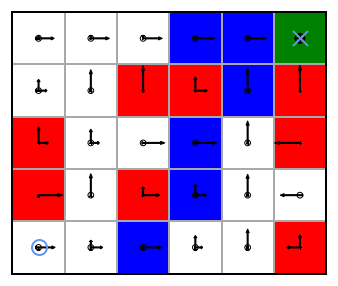

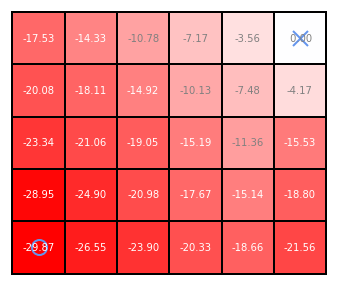

In [8]:
# Expert has a optimal policy
# vi_res = ValueIteration().plan_on(mdp)
# expert_policy = vi_res.policy
# mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)

# Use the Maximum Entropy IRL policy to generate trajectories
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp.transition_matrix),
    reward_matrix=torch.tensor(mdp.reward_matrix),
    discount_rate=torch.tensor(mdp.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([2]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

expert_state_values = dict(zip(mdp.state_list, expert_erpi.state_values))
mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_state_values)


In [36]:
# Generate gen_iters of trajectories
gen_iters = 2
trajectories = []

for _ in range(gen_iters):
  # Starts at one of the labelled starting points
  trajectory = expert_policy.run_on(mdp)
  formatted_traj = {}
  formatted_traj['state_traj'] = trajectory.state_traj
  formatted_traj['action_traj'] = trajectory.action_traj
  # trajectory = {'state_traj': (1, 2, 3, 4, 5),
  #               'action_traj': (2, 7, 9, 5, 1)}
  trajectories.append(formatted_traj)


In [470]:
# Get trajectory_weights
# what does it mean for a trajectory to be equal? only states are equal or both states and actions are equal
trajectory_weights = buildTrajWeights(trajectories)

In [471]:
the_weights = maxLikelihoodIRL(mdp, feature_matrix, trajectories, trajectory_weights, iters=10).detach().numpy()

Initial weights: tensor([-0.1456,  1.3136], dtype=torch.float64)
None
tensor([-3.0853, 18.1190], dtype=torch.float64)
Weights after iter 0: tensor([  2.9397, -16.8054], dtype=torch.float64, requires_grad=True)
tensor([3.6238e+00, 1.9189e-07], dtype=torch.float64)
Weights after iter 1: tensor([ -0.6841, -16.8054], dtype=torch.float64, requires_grad=True)
tensor([-1.7535e+00,  1.7857e-07], dtype=torch.float64)
Weights after iter 2: tensor([  1.0694, -16.8054], dtype=torch.float64, requires_grad=True)
tensor([3.7699e+00, 1.6188e-07], dtype=torch.float64)
Weights after iter 3: tensor([ -2.7006, -16.8054], dtype=torch.float64, requires_grad=True)
tensor([-2.5788e+00,  2.0868e-07], dtype=torch.float64)
Weights after iter 4: tensor([ -0.1218, -16.8054], dtype=torch.float64, requires_grad=True)
tensor([-9.9611e-01,  1.6196e-07], dtype=torch.float64)
Weights after iter 5: tensor([  0.8743, -16.8054], dtype=torch.float64, requires_grad=True)
tensor([2.1318e+00, 1.5667e-07], dtype=torch.float64)


In [472]:
the_weights = torch.tensor(the_weights)

tensor([  0.7963, -16.8054], dtype=torch.float64)


In [477]:
print(f"Final reward weights: {the_weights}")


Final reward weights: tensor([  0.7963, -16.8054], dtype=torch.float64)


In [473]:
step_cost_matrix = create_step_cost_matrix(mdp)

feature_reward_matrix = torch.einsum(
    "sanf,f->san",
    feature_matrix,
    the_weights
)

# construct the final reward function by taking into account each action's step cost
reward_matrix = feature_reward_matrix + step_cost_matrix


In [474]:
my_erpi_params = dict(
    transition_matrix=torch.tensor(mdp.transition_matrix),
    reward_matrix=reward_matrix,
    discount_rate=torch.tensor(mdp.discount_rate),
    entropy_weight=torch.tensor([2]), # the lower this is, the more optimal the policy
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

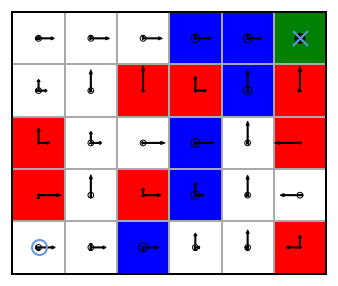

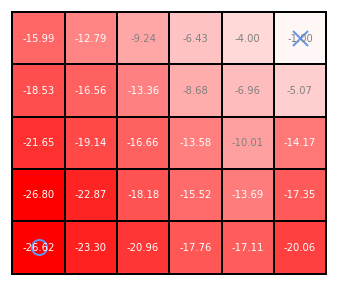

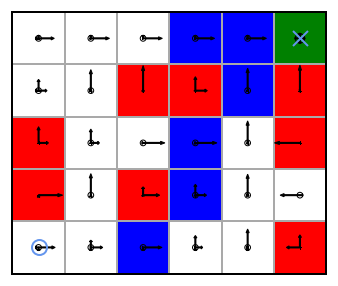

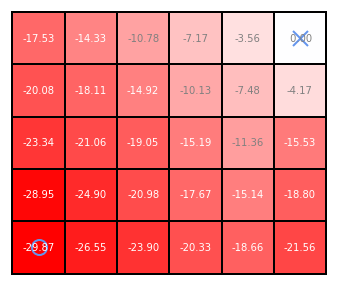

In [475]:
# solve with matrices returned by gridworld object
my_erpi = entropy_regularized_policy_iteration(
    **my_erpi_params
)

my_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=my_erpi.policy.detach().numpy()
)


my_state_values = dict(zip(mdp.state_list, my_erpi.state_values))
mdp.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp.plot().plot_state_map(my_state_values)

mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_state_values)


In [476]:
print(my_policy.evaluate_on(mdp).initial_value)
print(expert_policy.evaluate_on(mdp).initial_value)


-13.85978944764074
-12.367873729081428


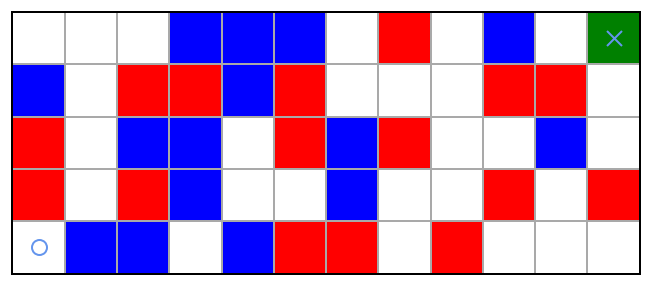

In [479]:
# Create a gridworld
mdp_params2 = dict(
    tile_array=[
        "...bbb.x.b.g",
        "b.xxbx...xx.",
        "x.bb.xbx..b.",
        "x.xb..b..x.x",
        "sbb.bxx.x...",
    ],
    feature_rewards={
        "x": -100,
        "b": 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=1-1e-5,
    step_cost=-1
)
mdp2 = GridWorld(**mdp_params2)

featurecolors = {
    'g': 'green',
    'x': 'red',
    '.': 'white',
    'b': 'blue'
}
mdp2.plot(featurecolors=featurecolors)


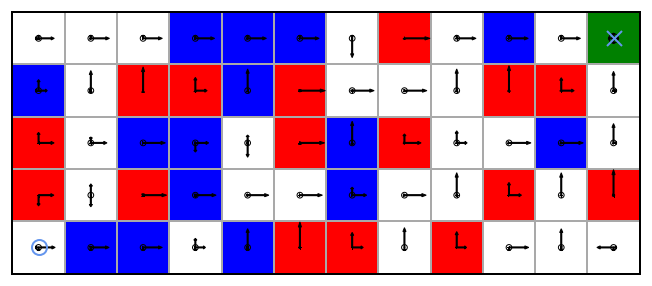

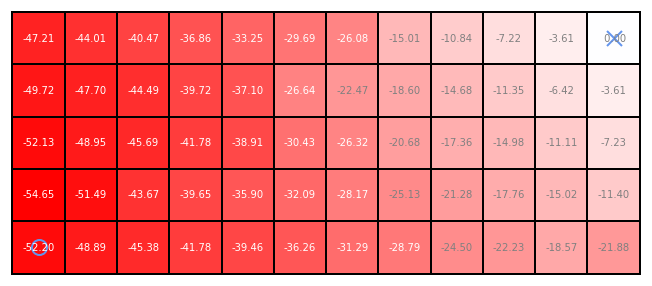

In [480]:
# Use the Maximum Entropy IRL policy to generate trajectories
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=torch.tensor(mdp2.reward_matrix),
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([2]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

expert_state_values = dict(zip(mdp2.state_list, expert_erpi.state_values))
mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)

In [481]:
features = sorted(mdp_params2['feature_rewards'].keys())
features = [f for f in features if f not in 'gs']
feature_matrix = buildFeatures(mdp2, features)

step_cost_matrix = create_step_cost_matrix(mdp2)

feature_reward_matrix = torch.einsum(
    "sanf,f->san",
    feature_matrix,
    the_weights
)

# construct the final reward function by taking into account each action's step cost
reward_matrix = feature_reward_matrix + step_cost_matrix

my_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=reward_matrix,
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([2]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)


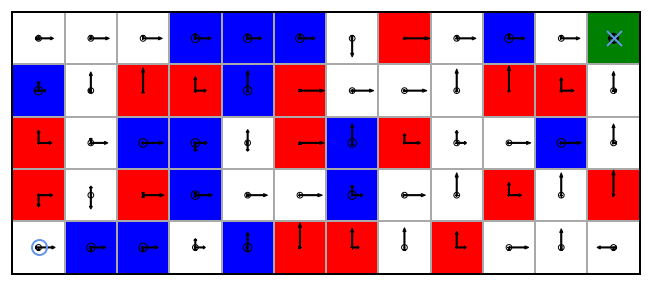

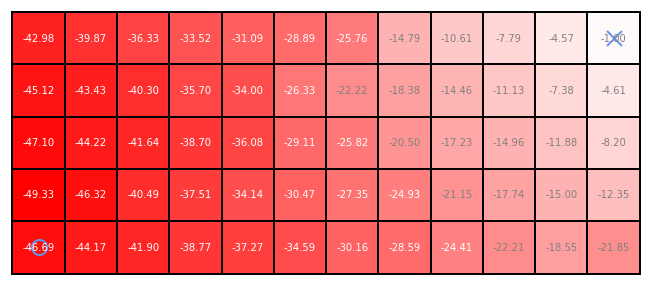

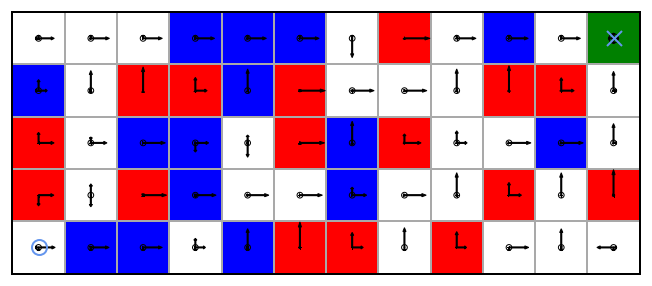

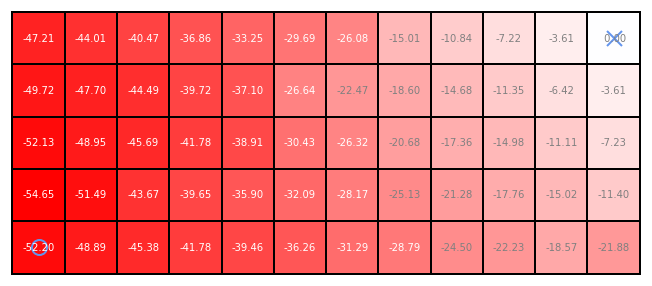

In [482]:
# solve with matrices returned by gridworld object
my_erpi = entropy_regularized_policy_iteration(
    **my_erpi_params
)

my_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=my_erpi.policy.detach().numpy()
)


my_state_values = dict(zip(mdp2.state_list, my_erpi.state_values))
mdp2.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp2.plot().plot_state_map(my_state_values)

mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)


In [483]:
print(my_policy.evaluate_on(mdp2).initial_value)
print(expert_policy.evaluate_on(mdp2).initial_value)

-22.742803082793476
-20.09068289652644
